In [1]:
!pip -q install pandas numpy matplotlib textstat openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.1 MB/s eta 0:00:00


In [2]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textstat
from openai import OpenAI

pd.set_option("display.max_colwidth", 160)


Upload the CSV

In [3]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("persona_feedback_outputs.csv")
df.head()


Saving persona_feedback_outputs.csv to persona_feedback_outputs.csv


,essay_id,persona,essay,feedback,rubric
0,1,critic,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ...","Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."
1,1,explainer,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...",Here is feedback you can use to improve your paragraph:\n\n1. Clarity:\n- Your main idea is clear: you believe school uniforms should be banned because they...,"Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."
2,1,supporter,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","You’ve done a great job stating your opinion clearly and acknowledging the opposing view, which makes your paragraph balanced and thoughtful. Your main reas...","Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."
3,1,planner,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...",Here is some feedback to help you improve your paragraph:\n\n1. Clarity:\n- Your main idea is that school uniforms should be banned because they limit stude...,"Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."
4,1,combined,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","Here is some clear, structured feedback to help you improve your paragraph:\n\n1. **State Your Opinion Clearly at the Start** \n Begin with a strong topi...","Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."


In [4]:
keep_personas = ["combined", "critic", "explainer", "supporter", "planner"]
df3 = df[df["persona"].isin(keep_personas)].copy()

df3["essay"] = df3["essay"].fillna("")
df3["feedback"] = df3["feedback"].fillna("")

print("Rows:", len(df3))
print("Personas:", sorted(df3["persona"].unique()))
df3.head()


Rows: 10
Personas: ['combined', 'critic', 'explainer', 'planner', 'supporter']


,essay_id,persona,essay,feedback,rubric
0,1,critic,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ...","Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."
1,1,explainer,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...",Here is feedback you can use to improve your paragraph:\n\n1. Clarity:\n- Your main idea is clear: you believe school uniforms should be banned because they...,"Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."
2,1,supporter,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","You’ve done a great job stating your opinion clearly and acknowledging the opposing view, which makes your paragraph balanced and thoughtful. Your main reas...","Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."
3,1,planner,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...",Here is some feedback to help you improve your paragraph:\n\n1. Clarity:\n- Your main idea is that school uniforms should be banned because they limit stude...,"Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."
4,1,combined,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","Here is some clear, structured feedback to help you improve your paragraph:\n\n1. **State Your Opinion Clearly at the Start** \n Begin with a strong topi...","Focus on four aspects: clarity, structure, strength of argument, and suggestions for improvement. Feedback should be specific enough that the student can ed..."


Define feedback presentation styles

In [5]:
client = None
api_key = os.getenv("OPENAI_API_KEY", "").strip()
if api_key:
    client = OpenAI(api_key=api_key)

MODEL = "gpt-4.1-mini"


In [6]:
def llm_reformat_feedback(style: str, feedback: str, essay: str = "") -> str:
    if client is None:
        return ""
    style_map = {
        "raw": "Return the feedback as is, with no changes.",
        "short_actions": (
            "Rewrite the feedback into 3 to 5 short actionable bullet points. "
            "Each bullet must start with a verb. No long paragraphs."
        ),
        "step_by_step": (
            "Rewrite the feedback into a step-by-step revision plan with numbered steps (1 to 6). "
            "Each step must be one sentence."
        ),
        "questions_first": (
            "Rewrite the feedback starting with 3 reflective questions for the learner, "
            "then provide 3 actionable steps."
        ),
    }

    instruction = style_map.get(style, style_map["raw"])
    prompt = (
        "You are helping design educational feedback for student writing.\n\n"
        f"STYLE:\n{style}\n\n"
        f"INSTRUCTIONS:\n{instruction}\n\n"
        "STUDENT PARAGRAPH:\n"
        f"{essay}\n\n"
        "ORIGINAL FEEDBACK:\n"
        f"{feedback}\n\n"
        "Return only the reformatted feedback."
    )

    resp = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "You format feedback to support student revision."},
            {"role": "user", "content": prompt},
        ],
        temperature=0.2,
    )
    return resp.choices[0].message.content.strip()


Generate reformatted feedback variants

In [7]:
styles = ["raw", "short_actions", "step_by_step", "questions_first"]

rows = []
for _, r in df3.iterrows():
    for s in styles:
        out = r["feedback"] if s == "raw" else llm_reformat_feedback(s, r["feedback"], r["essay"])
        rows.append(
            {
                "essay_id": r["essay_id"],
                "persona": r["persona"],
                "style": s,
                "essay": r["essay"],
                "feedback_original": r["feedback"],
                "feedback_variant": out,
            }
        )

ux_df = pd.DataFrame(rows)
ux_df.head()


,essay_id,persona,style,essay,feedback_original,feedback_variant
0,1,critic,raw,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ..."
1,1,critic,short_actions,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ...",- Separate opposing views into different sentences for clarity. \n- Specify what “it” refers to and explain why uniforms may not improve behaviour. \n- St...
2,1,critic,step_by_step,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ...",1. Begin your paragraph with a clear topic sentence that states your main argument against school uniforms. \n2. Separate the opposing views into different...
3,1,critic,questions_first,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ...",1. How clearly have you separated your own opinion from the opposing viewpoint in your paragraph? \n2. Does your paragraph begin with a strong topic senten...
4,1,explainer,raw,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...",Here is feedback you can use to improve your paragraph:\n\n1. Clarity:\n- Your main idea is clear: you believe school uniforms should be banned because they...,Here is feedback you can use to improve your paragraph:\n\n1. Clarity:\n- Your main idea is clear: you believe school uniforms should be banned because they...


Define proxy metrics for learner experience

In [8]:
ACTION_VERBS = {
    "add","remove","revise","rewrite","clarify","explain","support","compare","state","organise","organize",
    "combine","split","define","summarise","summarize","replace","tighten","expand","include","check","edit",
    "use","avoid","introduce","conclude","improve","focus","justify","connect"
}

def word_count(t: str) -> int:
    return len(re.findall(r"\b\w+\b", t or ""))

def sentence_count(t: str) -> int:
    return len([s for s in re.split(r"[.!?]+", t or "") if s.strip()])

def bullet_or_step_count(t: str) -> int:
    t = t or ""
    bullets = len(re.findall(r"^\s*[-•]\s+", t, flags=re.MULTILINE))
    numbered = len(re.findall(r"^\s*\d+[\).\]]\s+", t, flags=re.MULTILINE))
    return bullets + numbered

def question_count(t: str) -> int:
    return (t or "").count("?")

def action_verb_hits(t: str) -> int:
    tokens = [w.lower() for w in re.findall(r"\b[a-zA-Z]+\b", t or "")]
    return sum(1 for w in tokens if w in ACTION_VERBS)

def flesch_safe(t: str) -> float:
    try:
        return float(textstat.flesch_reading_ease(t or ""))
    except Exception:
        return np.nan

ux_df["wc"] = ux_df["feedback_variant"].apply(word_count)
ux_df["sc"] = ux_df["feedback_variant"].apply(sentence_count)
ux_df["step_count"] = ux_df["feedback_variant"].apply(bullet_or_step_count)
ux_df["q_count"] = ux_df["feedback_variant"].apply(question_count)
ux_df["action_hits"] = ux_df["feedback_variant"].apply(action_verb_hits)
ux_df["flesch"] = ux_df["feedback_variant"].apply(flesch_safe)

ux_df.head()


,essay_id,persona,style,essay,feedback_original,feedback_variant,wc,sc,step_count,q_count,action_hits,flesch
0,1,critic,raw,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ...",207,23,4,0,7,40.718809
1,1,critic,short_actions,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ...",- Separate opposing views into different sentences for clarity. \n- Specify what “it” refers to and explain why uniforms may not improve behaviour. \n- St...,55,5,5,0,4,37.237273
2,1,critic,step_by_step,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ...",1. Begin your paragraph with a clear topic sentence that states your main argument against school uniforms. \n2. Separate the opposing views into different...,111,12,6,0,9,35.177576
3,1,critic,questions_first,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...","1. Clarity: The paragraph mixes two opposing views in one sentence, which makes it confusing. Instead of combining “students need freedom” and “some people ...",1. How clearly have you separated your own opinion from the opposing viewpoint in your paragraph? \n2. Does your paragraph begin with a strong topic senten...,106,12,6,3,4,44.970000
4,1,explainer,raw,"School uniforms should be banned because students need freedom to express themselves, but some people think uniforms help with discipline and focus. I belie...",Here is feedback you can use to improve your paragraph:\n\n1. Clarity:\n- Your main idea is clear: you believe school uniforms should be banned because they...,Here is feedback you can use to improve your paragraph:\n\n1. Clarity:\n- Your main idea is clear: you believe school uniforms should be banned because they...,389,30,22,0,23,53.589026


LLM scoring for clarity and actionability

In [10]:

import json, re, time
import pandas as pd
import numpy as np

# 0) Clean duplicate columns (this is what caused the "double clarity" etc)
ux_df = ux_df.loc[:, ~ux_df.columns.duplicated()].copy()

# 1) Ensure the 3 score columns exist
for col in ["clarity", "actionability", "cognitive_load"]:
    if col not in ux_df.columns:
        ux_df[col] = pd.NA

# 2) LLM scoring function (always returns a dict with the 3 keys, or None)
def score_feedback_llm(feedback: str):
    if feedback is None or str(feedback).strip() == "":
        return None

    prompt = (
        "You are scoring feedback given to a secondary school student.\n"
        "Return JSON only. No extra text.\n"
        "Scores must be integers from 1 to 5.\n\n"
        "Keys:\n"
        "clarity: how easy it is to understand\n"
        "actionability: how easy it is to apply and edit\n"
        "cognitive_load: how mentally demanding it feels (5 = very demanding)\n\n"
        f"FEEDBACK:\n{feedback}"
    )

    resp = client.chat.completions.create(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": "Return only valid JSON. No extra text."},
            {"role": "user", "content": prompt},
        ],
        temperature=0.0,
    )

    raw = resp.choices[0].message.content.strip()

    # Try parse as pure JSON
    try:
        d = json.loads(raw)
    except Exception:
        # Fallback: extract first JSON object from text
        m = re.search(r"\{.*\}", raw, flags=re.DOTALL)
        if not m:
            return None
        try:
            d = json.loads(m.group(0))
        except Exception:
            return None

    # Normalise
    out = {}
    for k in ["clarity", "actionability", "cognitive_load"]:
        v = d.get(k, None)
        try:
            v = int(v)
        except Exception:
            v = None
        if v is None or v < 1 or v > 5:
            return None
        out[k] = v

    return out


# 3) Build mask of rows that should be scored:
# - has feedback text
# - AND is missing at least one of the 3 scores
def rows_to_score_mask(df):
    has_text = df["feedback_variant"].fillna("").str.strip().str.len().gt(0)
    missing_any = df[["clarity", "actionability", "cognitive_load"]].isna().any(axis=1)
    return has_text & missing_any


# 4) Score in batches with retries
max_rounds = 3

for round_i in range(1, max_rounds + 1):
    mask = rows_to_score_mask(ux_df)
    n = int(mask.sum())
    print(f"Round {round_i}: rows to score = {n}")
    if n == 0:
        break

    scored = ux_df.loc[mask, "feedback_variant"].apply(score_feedback_llm)

    # turn list-of-dicts into dataframe safely
    scored_df = pd.DataFrame(scored.tolist())

    # make sure required columns exist
    for col in ["clarity", "actionability", "cognitive_load"]:
        if col not in scored_df.columns:
            scored_df[col] = pd.NA

    scored_df = scored_df[["clarity", "actionability", "cognitive_load"]]
    scored_df.index = ux_df.loc[mask].index

    # assign back
    ux_df.loc[mask, ["clarity", "actionability", "cognitive_load"]] = scored_df

    # small pause helps reduce rate issues
    time.sleep(0.5)


# 5) Final check
print("\nMissing after scoring:")
print(ux_df[["clarity", "actionability", "cognitive_load"]].isna().sum())

# Show any rows still failing so you can see why
mask_left = rows_to_score_mask(ux_df)
if mask_left.sum() > 0:
    print("\nExample rows still missing scores:")
    display(ux_df.loc[mask_left, ["persona", "style", "feedback_variant", "clarity", "actionability", "cognitive_load"]].head(10))
else:
    print("\nAll rows scored successfully.")


Round 1: rows to score = 40
Round 2: rows to score = 0

Missing after scoring:
clarity           0
actionability     0
cognitive_load    0
dtype: int64

All rows scored successfully.


Summarise results by persona and style

In [12]:
summary = (
    ux_df.groupby(["persona","style"])[
        ["wc","step_count","q_count","action_hits","flesch","clarity","actionability","cognitive_load"]
    ]
    .mean()
    .reset_index()
    .sort_values(["persona","style"])
)

summary


,persona,style,wc,step_count,q_count,action_hits,flesch,clarity,actionability,cognitive_load
0,combined,questions_first,138.0,3.0,3.0,7.0,43.241082,5.0,5.0,3.0
1,combined,raw,260.0,14.0,0.0,14.5,42.166122,5.0,5.0,2.5
2,combined,short_actions,42.0,5.0,0.0,5.0,46.752077,5.0,5.0,3.0
3,combined,step_by_step,106.5,6.0,0.0,7.5,41.142095,5.0,5.0,3.0
4,critic,questions_first,112.5,4.5,3.0,6.0,44.226751,5.0,5.0,2.5
5,critic,raw,200.5,4.0,0.0,7.5,42.069422,4.5,5.0,3.0
6,critic,short_actions,49.0,5.0,0.0,4.5,37.990241,5.0,5.0,3.0
7,critic,step_by_step,115.5,6.0,0.0,7.5,36.478788,5.0,5.0,3.0
8,explainer,questions_first,127.0,3.0,3.0,8.5,45.422430,5.0,5.0,3.0
9,explainer,raw,362.0,19.0,0.0,15.5,48.655786,4.5,5.0,2.5


Visualise the design trade-offs

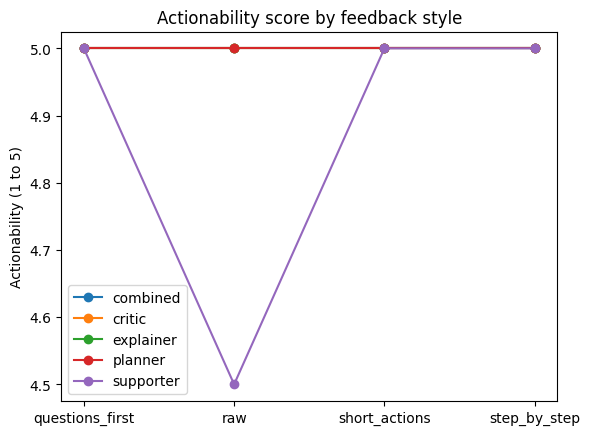

In [13]:
plt.figure()
data = summary.pivot(index="style", columns="persona", values="actionability")
for col in data.columns:
    plt.plot(data.index, data[col], marker="o", label=col)
plt.title("Actionability score by feedback style")
plt.ylabel("Actionability (1 to 5)")
plt.xticks(rotation=0)
plt.legend()
plt.show()


Cognitive load by style

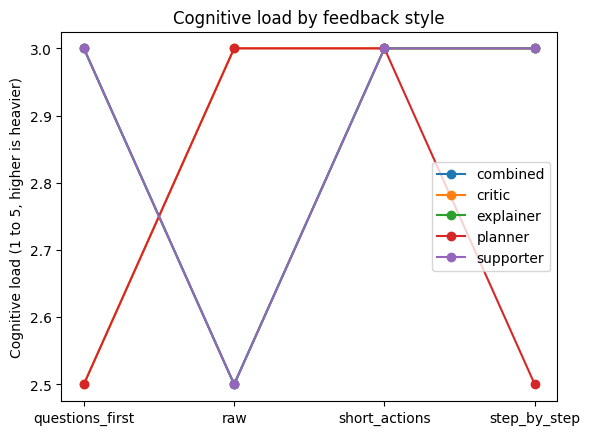

In [14]:
plt.figure()
data = summary.pivot(index="style", columns="persona", values="cognitive_load")
for col in data.columns:
    plt.plot(data.index, data[col], marker="o", label=col)
plt.title("Cognitive load by feedback style")
plt.ylabel("Cognitive load (1 to 5, higher is heavier)")
plt.xticks(rotation=0)
plt.legend()
plt.show()


Save outputs

In [15]:
ux_df.to_csv("project3_feedback_design_rows.csv", index=False)
summary.to_csv("project3_feedback_design_summary.csv", index=False)

from google.colab import files
files.download("project3_feedback_design_rows.csv")
files.download("project3_feedback_design_summary.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Interpretation of Results**

This analysis examined how different AI feedback designs influence clarity, actionability, and cognitive load across personas and feedback styles.

**Overall patterns**

*   Across personas, actionability scores were consistently high (mostly 5/5).
*   This suggests that most feedback variants provided clear next steps, regardless of persona.
*   Differences between styles were more visible in cognitive load and length, rather than in actionability alone.

**Feedback style trade-offs**


1.   Raw feedback

*   Longest responses by word count.
*   Higher step counts and action hits.
*   Associated with higher cognitive load in several personas.
*   Indicates rich detail, but at the cost of increased learner effort.


2.   Short actions

*   Shortest feedback variants.
*   Maintained high clarity and actionability.
*   Suggests efficiency without loss of usefulness.
*   Cognitive load remained moderate.



3.  Step-by-step

*   Balanced structure and clarity.
*   Slightly longer than short actions but more structured.
*   Cognitive load generally stable.
*   Supports learners who benefit from explicit sequencing.


4.  Questions first

*   Moderate length.

*   Encouraged reflection through question prompts.
*   Cognitive load varied by persona.


*  May suit exploratory or formative learning contexts.


**Persona-level observations**

1.   Explainer and planner personas

*   Produced longer feedback with more structured steps.
*   Often associated with higher cognitive load.
*   Suitable for learners who prefer guided explanations.

2.   Supporter persona

*   Maintained high clarity with slightly lower cognitive load in some styles.

*   Suggests affective tone may reduce perceived effort.

3.   Combined feedback

*   High clarity and actionability.
*   Tended to be longer and more demanding cognitively.
*   Highlights a trade-off between completeness and learner effort.


**Key insight**

There is no single “best” feedback style.

*  Concise formats (short actions) maximise efficiency.

*  Structured formats (step-by-step) balance clarity and support.
*  Comprehensive formats (raw, combined) increase cognitive demand.


Effective AI feedback design should therefore be adaptive, matching feedback style to learner needs and context rather than optimising for a single metric.

**Limitations**

*   Small, exploratory dataset.

*   LLM-based scoring reflects perceived qualities, not measured learning outcomes.
*   Results illustrate design tendencies rather than generalisable effects.
